In [2]:
# imports and data collection functions
import requests
def get_usgs_sf(state, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&stateCd=%s&startDT=%s-01-01&endDT=%s-12-31&siteType=ST&parameterCd=00060&statCd=00003" % (state,start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data for',state,'; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}
def get_usgs_sf2(state, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&stateCd=%s&startDT=%s&endDT=%s&siteType=ST&parameterCd=00060&statCd=00003" % (state,start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data for',state,'; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}
def get_usgs_sf_code(code, start_date, end_date):
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&sites=%s&&startDT=%s-01-01&endDT=%s-12-31&siteType=ST&parameterCd=00060&statCd=00003" % (code, start_date, end_date)
    try:
        req = requests.post(waterservices)
        return req.json()
    except:
        print ('Error trying to retrieve data; retrying')
        #time.sleep(5)
        try:
            req = requests.post(waterservices)
            return req.json()
        except:
            return {"error": "Error on USGS access"}

# Date collection
def get_gw_date(data, site, index):
    return data["value"]["timeSeries"][site]["values"][0]["value"][index]["dateTime"][0:10]
# Value
def get_gw_value(data, site, index):
    return float(data["value"]["timeSeries"][site]["values"][0]["value"][index]["value"])
def num_of_reps(data, site):
    return len(data["value"]["timeSeries"][site]["values"][0]["value"])
# Site name
def get_site(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteName"]
def get_site_code(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteCode"][0]["value"]
# Coordinates
def get_coordinates(data, site):
    coordinates = [float(data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["latitude"]), float(data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["longitude"])]
    return coordinates
# Show all data for a site
def show_site_data(data, site, print_data):
    graph = {}
    values_len = len(data["value"]["timeSeries"][site]["values"][0]["value"])
    if values_len == 0:
        return 0
    for i in range(values_len):
        if print_data:
            print(f"   {get_gw_date(data, site, i)}:  {get_gw_value(data, site, i)}")
        if float(get_gw_value(data, site, i)) > -10000000 and float(get_gw_value(data, site, i)) < 10000000:
            graph[get_gw_date(data, site, i)] = get_gw_value(data, site, i)
    return graph

In [3]:
# get_station_info(data[], "state", "start_date", "end_date")
import datetime as dt

'''
find sites with most data
    weekly
    daily
look at value length
need 30+ years of data too

datetime import (learn that!)
'''
def sortkey3(e):
    return e[5]

def get_station_info(data, start_date, end_date):
    stations = []
    start = dt.datetime(int(start_date), 1, 1)
    end = dt.datetime(int(end_date), 12, 31)
    difference = end - start
    print(difference.days)
    for i in range(len(data["value"]["timeSeries"])):
        reps = num_of_reps(data, i)
        #if reps > 9999:
        stations.append([i, get_site(data, i) ,f'{reps} total entries', get_gw_date(data, i, 0), f"SiteCode = {get_site_code(data, i)}", difference.days - reps])
    stations.sort(key=sortkey3)
    nums = []
    site_codes = {}
    for i in stations:
        #print(i)
        #if i[5] < 999:
        #print(f'{i[0]}    {i[1]}\n\t   {i[2]}, first entry: ({i[3]}), {i[4]}, Missing days: {i[5]}')
        site_codes[i[4][11:]] =  i[5]
        # print(f'{i[0]}    {i[1]}\n\t   {i[2]}, first entry: ({i[3]})\n\t\t{i[4]}\n')
        nums.append(i[0])
    #print(nums)
    #print(len(nums))
    print(site_codes)
    print(len(site_codes))

In [4]:
# graph_comparison(data[], "date", "start_date", "end_date", index_of_site, window_in_wks, if_plotting, percentile) & daily_analysis()
# daily_analysis(graph[], start(dt), end(dt), "date", "end_date", start2(dt))
# change in gw levels for one station, sorted from decrease to increase
import matplotlib.pyplot as plt
import numpy as np

MONTH_DATA = [31,28,31,30,31,30,31,31,30,31,30,31,31]
# Avg every day
import datetime as dt
MON_ACCUM = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

def daily_analysis(graph, start, end, date, end_date, start2):
    # returns list of that week average over all years
    date_data = []
    for date in list(graph.keys()):
        #print(str(graph(date)))
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    while start.year < int(end_date):
        lst = []
        accum = 0
        for i in date_data:
            if i[0] >= start and i[0] <= end:
                lst.append(i)
                accum += i[1]
        if len(lst):
            total_data.append([start2.year, accum / len(lst)])
        #if start.year % 4 == 0 and start.month == 2:
            # LEAP YEAR
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
        end = dt.datetime(end.year + 1, end.month, end.day)
    return total_data

def daily_no_avg(graph, start, date, end_date, start2, scope, typ):
    # returns list of that week average over all years
    date_data = []
    for date in list(graph.keys()):
        #print(str(graph(date)))
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    # just take first day and next first day
    while start.year < int(end_date):
        lst2 = []
        accum = 0
        min = 1000000
        for i in range(len(date_data)):
            if date_data[i][0] >= start - dt.timedelta(days=scope) and date_data[i][0] <= start + dt.timedelta(days=scope):
                lst2.append(date_data[i])
                if typ == 'avg':
                    accum += date_data[i][1]
                elif typ == "min" and date_data[i][1] < min:
                    min = date_data[i][1]
        if len(lst2) >= 2:
            if typ == "avg":
                total_data.append([start2.year, accum/len(lst2)])
            elif typ == "min":
                total_data.append([start2.year, min])
        #if start.year % 4 == 0 and start.month == 2:
            # LEAP YEAR
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
    return total_data

def sortkey2(e):
    return e[1]

def graph_comparison(graph, date, start_date, end_date, index_of_site, window, plotting, percentile, scope, typ):
    if len(date) == 5:
        start = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
        start2 = start + dt.timedelta(weeks=window * 2)
        end2 = start + dt.timedelta(weeks=3 * window,days=-1)
    first_set = daily_no_avg(graph[0], start, date, end_date, start, scope, typ)
    second_set = daily_no_avg(graph[1], start2, date, end_date, start, scope, typ)
    plottable = []
    for i in first_set:
        for j in second_set:
             if j[0] == i[0]:
                  plottable.append([i[0], j[1] - i[1]])
    dct = {}
    plottable.sort(key=sortkey2)
    for i in plottable:
        if plotting:
            dct[(str(i[0]))[2:4]] = i[1]
        else:
            dct[(str(i[0]))] = i[1]
    if plotting:
        plt.bar(dct.keys(), dct.values(), color = "green", width = 0.8)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.title("Streamflow (%s) versus period after" % (date))
        plt.show()
        #for i in dct.keys():
            #print(f'{i}: {dct[i]:.2f}')
    else:
        #print(f'dct is {dct}')
        if len(dct) > 0:
            if percentile != 0:
                a = list(dct.values())
                a = np.array(a)
                p = np.percentile(a, percentile)  # return 50th percentile, i.e. median.
                return p
            else:
                # [mean, median, interquartile range,standard deviation]
                b = list(dct.values())
                b = np.array(b)
                return [list(dct.values()), np.mean(b), np.median(b), np.percentile(b, 75) - np.percentile(b, 25), np.std(b),start.strftime("%m/%d"), end2.strftime("%m/%d"), list(dct.keys())]
        else:
            return False

In [5]:
# percent(data[], "date", "start_date", "end_date", percentile, "state", "station")
NY_STATIONS = [580, 538, 520, 483, 498, 559, 537, 598, 501, 477, 500, 572, 497, 328, 426, 40, 19, 589]
VT_STATIONS = [13, 14]
MA_STATIONS = [90, 165, 163, 119, 150, 144]
ME_STATIONS = [2]
CT_STATIONS = [71, 48, 11, 32, 49, 33, 35, 42, 62, 34]
RI_STATIONS = [3, 5, 4]
def percent(data, date, start_date, end_date, percentile, state, station, scope):
    graph = show_site_data(data, station, False)
    match state:
        case "NY":
            lookat = NY_STATIONS
        case "VT":
            lookat = VT_STATIONS
        case "MA":
            lookat = MA_STATIONS
        case "ME":
            lookat = ME_STATIONS
        case "CT":
            lookat = CT_STATIONS
        case "RI":
            lookat = RI_STATIONS
    all_stations = []
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    if station == "all":
        for item in lookat:
            one_station = []
            # DO FOR EVERY WEEK OF THE YEAR
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                one_station.append(graph_comparison(graph, f"{mo}-{da}", start_date, end_date, item, 0.5, False, percentile[0], scope))
            all_stations.append(one_station)
        for i in all_stations:
            plt.plot(range(52), i, color = (0,0, 1,1))
        plt.title("GW: %s percentile across %s stations" % (percentile[0], state))
    else:
        for i in percentile:
            all_stations = []
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                all_stations.append(graph_comparison(graph, f"{mo}-{da}", start_date, end_date, int(station), 0.5, False, i))
            plt.plot(range(52), all_stations, color = (i * 0.02,0,1 - i * 0.02,1))
        plt.title("GW: %sth percentile in station %s (%s)" % (percentile, station, get_site(data, int(station))))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
    return all_stations

In [6]:
# differences(data[], "date", "start_date", "end_date", index_of_site, week_window_compared) 
# (Utils graph_comparison(), not percent())
# SHOW DIFFERENT WAYS TO CALCULATE DIFFERENCES (Utils graph_comparison(), not percent())
def differences(data, date, start_date, end_date, index_of_site, window, scope):
    graph = show_site_data(data, index_of_site, False)
    PERCENTILES = [5, 10, 25, 33]
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    perm_diff1 = []
    perm_diff2 = []
    perm_diff3 = []
    perm_diff4 = []
    stat_lst = []
    curr_weeks = []
    for week in range(int(26 / window)):
        date2 = date + dt.timedelta(days= 7 * week * 2 * window)
        # investigate looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        stats = (graph_comparison(graph, f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0, scope))
        #print(stats)
        diff1 = []
        diff2 = []
        diff3 = []
        diff4 = []
        # [data, mean, median, interquartile range,standard deviation]
        if stats:
            curr_weeks.append(week)
            for value in stats[0]:
                diff1.append(value - stats[1])
                diff2.append(value - stats[2])
                diff3.append((value - stats[1])/stats[4])
                diff4.append((value - stats[2])/stats[3])
            # turn into percentiles and put into perm list for each week
            a = list(diff1)
            a = np.array(a)
            b = list(diff2)
            b = np.array(b)
            c = list(diff3)
            c = np.array(c)
            d = list(diff4)
            d = np.array(d)
            perm_diff1.append([np.percentile(a, PERCENTILES[0]),np.percentile(a, PERCENTILES[1]),np.percentile(a, PERCENTILES[2]),np.percentile(a, PERCENTILES[3])])
            perm_diff2.append([np.percentile(b, PERCENTILES[0]),np.percentile(b, PERCENTILES[1]),np.percentile(b, PERCENTILES[2]),np.percentile(b, PERCENTILES[3])])
            perm_diff3.append([np.percentile(c, PERCENTILES[0]),np.percentile(c, PERCENTILES[1]),np.percentile(c, PERCENTILES[2]),np.percentile(c, PERCENTILES[3])])
            perm_diff4.append([np.percentile(d, PERCENTILES[0]),np.percentile(d, PERCENTILES[1]),np.percentile(d, PERCENTILES[2]),np.percentile(d, PERCENTILES[3])])
            stat_lst.append(stats[1:])
            # INSTEAD OF APPEND EMPTY, MAKE X AXIS HAVE ASSIGNED WEEK VALUE STORED
    fig, axs = plt.subplots(2, 2)
    fig.suptitle("Station %s" % (get_site(data, index_of_site)))
    for i in range(len(perm_diff1[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff1)):
            temp.append(perm_diff1[j][i])
            temp2.append(stat_lst[j][0])
        #plt.plot(curr_weeks, temp, color = "green")
        #plt.plot(curr_weeks, temp2, color = "blue")
        axs[0, 0].plot(curr_weeks, temp, color = "green")
        axs[0, 0].plot(curr_weeks, temp2, color = "blue")
    axs[0, 0].set_title("Value - Mean")
    #plt.title("SF: difference calculcation 1 for station %s" % (get_site(data, index_of_site)))
    for i in range(len(perm_diff2[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff2)):
            temp.append(perm_diff2[j][i])
            temp2.append(stat_lst[j][1])
        axs[0, 1].plot(curr_weeks, temp, color = "green")
        axs[0, 1].plot(curr_weeks, temp2, color = "blue")
    axs[0, 1].set_title("Value - Median")
    #plt.title("SF: difference calculcation 2 for station %s" % (get_site(data, index_of_site)))
    for i in range(len(perm_diff3[0])):
        # permdiff3 across all weeks
        temp = []
        temp2 = []
        for j in range(len(perm_diff3)):
            temp.append(perm_diff3[j][i])
            temp2.append(stat_lst[j][3])
        axs[1, 0].plot(curr_weeks, temp, color = "green")
        #axs[1, 0].plot(curr_weeks, temp2, color = "blue")
    axs[1, 0].set_title("(Value - Mean) / STD")
    #plt.title("SF: difference calculcation 3 for station %s" % (get_site(data, index_of_site)))
    for i in range(len(perm_diff4[0])):
        temp = []
        temp2 = []
        for j in range(len(perm_diff4)):
            temp.append(perm_diff4[j][i])
            temp2.append(stat_lst[j][2])
        axs[1, 1].plot(curr_weeks, temp, color = "green")
        #axs[1, 1].plot(curr_weeks, temp2, color = "blue")
    axs[1, 1].set_title("(Value - Median) / IQR")
    #plt.title("SF: difference calculcation 4 for station %s" % (get_site(data, index_of_site)))
    for ax in axs.flat:
        ax.set(xlabel=f"Interval of {window * 2} weeks", ylabel='Value')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

In [7]:
# using_all_weeks(data[], "date", "start_date", "end_date", index_of_site, percent_of_total_outputted)
def sortkey(e):
    return e[0]

def using_all_weeks(data, date, start_date, end_date, index_of_site, percent, scope, typ):
    graph = show_site_data(data, index_of_site, False)
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    window = 0.5
    total_data = []
    date_data = []
    for week in range(int(26 / window) + 1):
        date_data.append({})
    for stat in graph:
        new_date = dt.datetime(int(stat[0:4]),int(stat[5:7]),int(stat[8:10]))
        date_data[((new_date.timetuple().tm_yday - 1) // 7)][stat] = graph[stat]
    for week in range(int(26 / window)):
        date2 = date + dt.timedelta(weeks= week * 2 * window)
        # investigate looking across year
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        #print(graph_comparison(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, True, 0))
        #graph_comparison(graph, f"{mo}-{da}", start_date, end_date, index_of_site, window, True, 0)
        info = (graph_comparison([date_data[week], date_data[week + 1]], f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0, scope, typ))
        # Need to gather full date of entry
        #ERROR
        if info:
            for i in range(len(info[0])):
                total_data.append([info[0][i],f"{info[7][i]}/{(info[5])} - {info[7][i]}/{info[6]}"])
    total_data.sort(key=sortkey)
    print(str(percent) + "%")
    for i in range(int(len(total_data) / (100 / percent))):
        print(f'{total_data[i][0]:.2f}: {total_data[i][1]}')

    print(str(100 - percent) + "%")
    for i in total_data[-1 * int(len(total_data) / (100 / percent)): -1]:
        print(f'{i[0]:.2f}: {i[1]}')
    return total_data[0:(int(int(len(total_data) / (100 / percent))))]
    #print("This data may be skewed because when only looking at one day compared to the next week day, if either day is missing, the\ndata gets tossed out. Therefore, plenty of years where there are great changes may be left out.\nThis can be solved by looking at each day of the week, starting at 01-01 to 01-06.")

In [8]:
# coord_clusters(state)
import math
GOOD_SITES = {'01304500': -1, '01305000': -1, '01305500': -1, '01308500': -1, '01315000': -1, '01315500': -1, '01318500': -1, '01321000': -1, '01325000': -1, '01334500': -1, '01336000': -1, '01346000': -1, '01347000': -1, '01350000': -1, '01351500': -1, '01357499': -1, '01357500': -1, '01362500': -1, '01365000': -1, '01371500': -1, '01372500': -1, '01375000': -1, '01413500': -1, '01414500': -1, '01415000': -1, '01417000': -1, '01420500': -1, '01421000': -1, '01426500': -1, '01428500': -1, '01436000': -1, '01437500': -1, '01500000': -1, '01503000': -1, '01509000': -1, '01512500': -1, '01521500': -1, '01523500': -1, '01524500': -1, '01526500': -1, '01529500': -1, '01531000': -1, '03011020': -1, '03014500': -1, '04215500': -1, '04223000': -1, '04227500': -1, '04230500': -1, '04231000': -1, '04231600': -1, '04234000': -1, '04235000': -1, '04243500': -1, '04249000': -1, '04252500': -1, '04256000': -1, '04258000': -1, '04260500': -1, '04262500': -1, '04263000': -1, '04264331': -1, '04266500': -1, '04273500': -1, '04216000': 0, '04237496': 4, '01367500': 177, '01303500': 180, '01423000': 272, '01306500': 352, '01308000': 364, '04217000': 364, '04268000': 364, '04269000': 365, '01304000': 454, '04213500': 547, '01435000': 567, '04229500': 731, '04239000': 863, '01425000': 911, '01358000': 959, '01200000': 1299, '01311500': 1641, '01510000': 1826, '04214500': 1826, '01502500': 2009, '04215000': 2037, '04228500': 2037, '01303000': 2971, '01310500': 3003, '04237500': 3014, '01309500': 3059, '01376800': 3255, '01505000': 3287, '01310000': 3470, '04232050': 3620, '04233000': 3744, '01417500': 3775, '04267500': 4017, '01365500': 4199, '04240100': 4640, '04227000': 4686, '04270000': 4840, '04242500': 4931, '01362200': 5020, '04230380': 5112, '01530500': 5205, '01520500': 5296, '04250750': 5428, '04270200': 5562, '04232482': 5568, '01312000': 5569, '04219000': 6067, '04235250': 6198, '04232000': 6301, '01302500': 6365, '01420980': 6666, '01433500': 6756, '01387450': 6785, '04262000': 6869, '01348000': 7030, '01500500': 7123, '04218000': 7149, '04221000': 7213, '01335754': 7305, '01364500': 7363, '04275000': 7465, '04240010': 7547, '01350180': 7714, '04271500': 7820, '04275500': 7821, '04276500': 7821, '04218518': 8308, '04240180': 8674, '04240105': 8763, '04235500': 8857, '04246500': 8857, '01311000': 8940, '04224775': 8975, '01529950': 9038, '01349000': 9063, '01350140': 9111, '01350120': 9157, '04240120': 9159, '01350355': 9339, '04240300': 9452, '01421900': 9562, '01422500': 9609, '01327750': 9830, '01331095': 9920, '01330000': 9953, '01333500': 10134, '04216418': 10134, '01330500': 10136, '01496500': 10136, '01502000': 10136, '01528000': 10136, '01306460': 10174, '01306495': 10598, '03013000': 10684, '01301500': 10737, '01387400': 10769, '01387420': 10769, '01329490': 10773, '0423205010': 11291, '01376500': 11314, '01309990': 11380, '04268800': 11472, '04245200': 11595, '0142400103': 11753, '01309950': 11771, '04273700': 11956, '04232100': 12086, '01300000': 12145, '01300500': 12145, '01302000': 12145, '01436500': 12145, '01434025': 12210, '01414000': 12484, '01301000': 12876, '04257000': 12876, '04216200': 12934, '01359750': 12966, '01427500': 13147, '04245000': 13241, '01350080': 13346, '01306499': 13474, '04240200': 13693, '01306440': 13890, '01514000': 14208, '01525500': 14244, '04217500': 14244, '01507000': 14246, '04216500': 14335, '0422026250': 14517, '04280450': 14668, '01328000': 14676, '01529000': 14702, '04261000': 14702, '01360640': 14882, '04271815': 15034, '01420000': 15067, '04245236': 15088, '01434017': 15155, '01434498': 15155, '04273800': 15247, '04279000': 15266, '01527000': 15317, '01513500': 15434, '01436690': 15613, '01361000': 15643, '04250200': 15648, '01528700': 15705, '01349150': 15790, '01369500': 15798, '04270510': 15949, '04278300': 16071, '01374701': 16094, '01374901': 16145, '01374821': 16151, '01374941': 16151, '0137462010': 16157, '01374505': 16159, '01374531': 16221, '01319000': 16284, '01428000': 16391, '04233300': 16502, '01361500': 16528, '01369000': 16528, '04265000': 16528, '0137449480': 16708, '01374559': 16708, '01374930': 16708, '04232034': 16743, '01374890': 16776, '04232650': 16802, '04227995': 16874, '01307500': 16893, '04276842': 16999, '01374598': 17028, '04244000': 17073, '04235600': 17074, '04247000': 17122, '01413408': 17139, '01362230': 17152, '01349700': 17161, '01362370': 17197, '01498500': 17249, '0143400680': 17253, '01505500': 17259, '01434021': 17334, '01350101': 17359, '01349711': 17439, '01349810': 17439, '01349950': 17439, '01362342': 17439, '01362497': 17439, '01413398': 17439, '01421618': 17439, '01419500': 17500, '01362198': 17531, '04225000': 17532, '04253295': 17733, '01350035': 17803, '013621955': 17803, '04235440': 17803, '04253294': 17803, '01329500': 17806, '01426000': 17989, '01437000': 17989, '04253500': 17989, '01349705': 18125, '04253296': 18145, '01527500': 18331, '04221500': 18354, '01306000': 18355, '01413088': 18419, '04235299': 18464, '01363382': 18484, '01421610': 18484, '01525981': 18535, '04274000': 18630, '01343060': 18784, '01374581': 18930, '01418500': 19085, '01422000': 19085, '01507500': 19085, '01526000': 19085, '04254500': 19085, '01317000': 19207, '01432900': 19265, '04233286': 19309, '01422747': 19329, '01327500': 19354, '01372300': 19357, '04237946': 19357, '01366650': 19358, '01307000': 19450, '01309000': 19450, '01510500': 19450, '01372200': 19508, '0136230002': 19569, '04265432': 19629, '01302050': 19692, '01358500': 19814, '04254000': 19814, '01314000': 19815, '01370000': 19815, '01373500': 19815, '01425500': 19815, '01497500': 19815, '01499000': 19815, '01501000': 19815, '01501500': 19815, '01508000': 19815, '01508500': 19815, '01522500': 19815, '04222000': 19815, '01371000': 19950, '01368500': 20179, '01366500': 20272, '01511500': 20272, '01374654': 20339, '04232730': 20361, '03011000': 20453, '04218500': 20453, '04235271': 20453, '04217750': 20485, '04270500': 20546, '01302020': 20679, '01372800': 20723, '01356190': 20784, '01374781': 20794, '04234061': 20818, '04237962': 20818, '01508803': 20871, '04232047': 20944, '04247055': 21090, '01434092': 21185, '01423500': 21276, '01424000': 21276, '01364959': 21397, '01505810': 21444, '04220045': 21521, '01311810': 21603, '01424500': 21642, '01374987': 21661, '04220250': 21784, '01359528': 21791, '01502632': 21822, '01502731': 21822, '01513831': 21822, '01530332': 21822, '0423401815': 21886, '01415500': 22007, '0423204920': 22031, '04235150': 22067, '0423205025': 22092, '03010820': 22146, '01362487': 22186, '01359519': 22194, '04256485': 22222, '01350200': 22270, '04258700': 22279, '01302125': 22280, '01425675': 22280, '01313500': 22372, '01349840': 22372, '01422389': 22372, '04274500': 22372, '01354500': 22496, '04219768': 22502, '04232040': 22576, '04234232': 22705, '04245840': 22734, '01421614': 22737, '01422738': 22737, '01362357': 22793, '04233255': 22796, '01362380': 22823, '0422016550': 22874, '04252000': 22897, '01362465': 22945, '01349900': 22949, '01359902': 22977, '01342730': 22978, '01359513': 22980, '01376280': 22983, '01374918': 22989, '0137499350': 22990, '04265100': 23009, '01359924': 23010, '04268600': 23010, '04268700': 23010, '04269500': 23010, '01361570': 23011, '01424108': 23011, '04232046': 23017, '04235276': 23062, '01350032': 23072, '01374976': 23078, '01349541': 23087, '01370500': 23103, '01418000': 23103, '04226000': 23133, '04276770': 23162, '04249200': 23312, '01363556': 23321, '01372850': 23324, '04225500': 23375, '01361200': 23378, '04235300': 23467, '01344000': 23468, '01343403': 23595, '01342602': 23635, '01339060': 23643, '04242640': 23647, '04236800': 23648, '04243783': 23648, '01349527': 23650, '01338000': 23657, '01342682': 23670, '04234254': 23676, '01328770': 23707, '0423406130': 23717, '01354083': 23755, '01427405': 23787, '0134277112': 23812, '0134277114': 23812, '01422700': 23832, '01362192': 23833, '01372100': 23833, '01342743': 23979, '01509150': 24014, '01372065': 24106, '04213450': 24128, '04240503': 24131, '01335500': 24198, '04258500': 24198, '04276069': 24257, '04276645': 24257, '04279040': 24257, '04279125': 24257, '01359133': 24307, '04269043': 24347, '01351000': 24349, '01315170': 24378, '01315226': 24378, '01315227': 24379, '0136219503': 24390, '01362322': 24423, '01362336': 24424, '01362368': 24454, '01514500': 24471, '0424014980': 24472, '01364800': 24530, '01387250': 24571, '04214200': 24622, '04214400': 24622, '04218450': 24622, '01501015': 24637, '04232200': 24675, '01372400': 24683, '04213319': 24691, '04213376': 24692, '04213410': 24713, '04213401': 24733, '04214231': 24733, '04213394': 24734, '0421422210': 24735, '04214060': 24736, '01199490': 24739, '01376270': 24746, '04220223': 24748, '01350212': 24791, '01498620': 24794, '01351298': 24796, '03010800': 24800, '01351200': 24803, '01350500': 24805, '01422779': 24817, '0423204140': 24822, '0423204141': 24823, '01350480': 24825, '0134277121': 24830, '04220500': 24836, '01434105': 24837, '04264700': 24837, '01344500': 24862, '0134277119': 24891, '04222900': 24928, '04228900': 24928, '04224650': 24945, '04221600': 24959, '01368050': 24974, '04220470': 24988, '04221720': 24988, '01370520': 25000, '0424015305': 25037, '01370600': 25049, '04265605': 25063, '01373600': 25080, '01365505': 25091, '01365550': 25092, '04234270': 25109, '04253275': 25109, '0426545295': 25109, '01362090': 25171, '01365100': 25189, '01359135': 25190, '01415460': 25194, '04232630': 25202, '04234018': 25202, '04234055': 25202, '04219940': 25220, '0134277123': 25234, '04213440': 25263, '01416500': 25294, '04234398': 25294, '0423245850': 25301, '04234200': 25323, '04235890': 25336, '04268200': 25406, '01433005': 25414, '01359918': 25445, '04221820': 25445, '04276895': 25458, '04276920': 25458, '0131199050': 25461, '0425040001': 25470, '04235820': 25471, '01376534': 25477, '0143402265': 25486, '01434013': 25487, '0427386410': 25518, '04273996': 25519, '04274051': 25524, '01436655': 25527, '01309680': 25545, '01437100': 25545, '01425805': 25547, '01434176': 25547, '01362182': 25566, '04237944': 25566, '01374420': 25568, '01374480': 25568, '01376600': 25568, '01376850': 25568, '01377300': 25568, '01390200': 25568, '01434086': 25568, '04268390': 25568, '04256480': 25574, '04237575': 25592, '01359150': 25598, '0426545290': 25628, '01373690': 25638, '01419000': 25659, '04241200': 25659, '04256460': 25659, '04240150': 25676, '0423205023': 25679, '01329650': 25728, '01387095': 25743, '01372051': 25751, '01376558': 25768, '01437349': 25771, '01530380': 25777, '04219915': 25834, '0422018610': 25834, '04233700': 25840, '01434080': 25841, '04249910': 25851, '01499050': 25871, '01507470': 25871, '01507975': 25871, '01513840': 25871, '01525750': 25871, '01526495': 25871, '01526980': 25871, '04213492': 25898, '01499470': 25902, '04245250': 25902, '04270800': 25931, '01374440': 25933, '01376900': 25933, '01377200': 25933, '01387300': 25933, '01387480': 25933, '01390300': 25933, '01434076': 25933, '01434084': 25933, '0423368620': 25949, '01327000': 25959, '01527050': 25963, '04240145': 25964, '0424016205': 25964, '0424016825': 25964, '0424016975': 25964, '01315081': 25968, '01513790': 25992, '04230650': 26008, '04218999': 26019, '01362100': 26048, '04231401': 26049, '03012834': 26052, '04232053': 26056, '0422027430': 26072, '01372040': 26085, '04213508': 26097, '01425642': 26113, '04232076': 26125, '04279001': 26139, '01434072': 26144, '01311992': 26145, '01434073': 26145, '04253000': 26175, '04213442': 26199, '04233678': 26206, '01434500': 26213, '04218601': 26222, '04218700': 26223, '01434087': 26226, '01362297': 26227, '01349858': 26240, '0423527080': 26259, '01508962': 26265, '03011550': 26296, '04237950': 26296, '01376275': 26297, '03013800': 26298, '01437400': 26331, '01513719': 26358, '04223500': 26390, '04270700': 26417, '04269050': 26418, '04218592': 26449, '01424998': 26484, '01513720': 26509, '01362232': 26526, '04219767': 26576, '04274185': 26577, '01337005': 26595, '01344795': 26623}
def sort_by_x(e):
    return e[1][0]
def sort_by_y(e):
    return e[1][1]
def sort_by_distance(e):
    return e[0]
def sort_prox(e):
    return e[1]

def coord_clusters(num_clusters, data):
    # only works for 3 currently, can fix though if desired
    num_of_stations = 3
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        stations.append([i,get_coordinates(data,i)])
    x_lst = stations.copy()
    y_lst = stations.copy()
    x_lst.sort(key = sort_by_x)
    y_lst.sort(key = sort_by_y)
    #print(len(y_lst))
    all_circles = []
    # HOW TO LOCATE 3 CLOSEST WITHOUT ITERATING THROUGH EVERY SINGLE ONE
    for i in range(len(data["value"]["timeSeries"])):
        # GIVES STARTING POINT IN LIST FOR STATION
        x_start = (next((n for n, sublist in enumerate(x_lst) if sublist[0] == i), None))
        y_start = (next((n for n, sublist in enumerate(y_lst) if sublist[0] == i), None))
        # WITH STARTING POINT, START LOOKING IN ALL 4 DIRECTIONS. DO FIRST 3, THEN JUST SWAP OUT LARGEST FOR SMALLER ONE AS PROGRESSES
        accum = 0
        #nearest = []
        nearest_prox = []
        r = 1000

        # min distance searched updates when the difference between whatever direction looking is less than curr value
        # if min distance searched is greater than radii, exit

        points = []
        while True:
            min_distance_searched = 1000
            accum += 1
            #print(accum)
            if x_start + accum < len(data["value"]["timeSeries"]) and x_lst[x_start + accum][0] not in points: # and if not already in list
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start + accum][0], abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1]) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start + accum][0], abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])}")
                if abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                # if r is less than nearest max, add to nearest and remove nearest max
            if x_start - accum >= 0 and x_lst[x_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start - accum][0], abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1]) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start - accum][0], abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])}")
                if abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                #r = abs(nearest[-1][1][0] - x_lst[x_start][1][0]) + abs(nearest[-1][1][1] - x_lst[x_start][1][0])
                # Look down x
            if y_start + accum < len(data["value"]["timeSeries"]) and y_lst[y_start + accum][0] not in points:
                #print(y_start + accum <= len(data["value"]["timeSeries"]))
                #print(len(data["value"]["timeSeries"]))
                if len(nearest_prox) < num_of_stations:       
                    nearest_prox.append([y_lst[y_start + accum][0], abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    #print(y_start + accum)
                    if abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1]) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start + accum][0], abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])}")
                if abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
                # Look up y
            if y_start - accum >= 0 and y_lst[y_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([y_lst[y_start - accum][0],abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1]) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start - accum][0], abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])}")
                if abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
                # Look down y
            #print((stations[nearest_prox[-1][0]][1]))
            #print(y_lst[y_start][1])
            #print(f'min_distance is {min_distance_searched}')
            #print(f'{nearest_prox} is nearest prox')
            #print(math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2))
            if min_distance_searched > math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2):
                break
        #print(f'{nearest_prox} is nearest prox')
        all_circles.append([math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2), i, nearest_prox[0][0], nearest_prox[1][0], nearest_prox[2][0], get_site_code(data,i), get_site_code(data,nearest_prox[0][0]), get_site_code(data,nearest_prox[1][0]), get_site_code(data,nearest_prox[2][0])])
        #print(all_circles[-1])
    all_circles.sort(key = sort_by_distance)
    #for i in range(num_clusters):
        #print(all_circles[i])
    alternate_lst = []
    for i in all_circles:
        if get_site_code(data, i[1]) in GOOD_SITES and get_site_code(data, i[2]) in GOOD_SITES and get_site_code(data, i[3]) in GOOD_SITES and get_site_code(data, i[4]) in GOOD_SITES:
            alternate_lst.append(i)
    print(alternate_lst)
    return alternate_lst[0:num_clusters]
    #return all_circles[0:num_clusters]
    #return all_circles[-10:-1]
    #PYTHAGOREAS


EXPONENT = 2
MULTIPLIER = 750
DIVIS = 365


def coord_clusters2(num_clusters, data):
    # only works for 3 currently, can fix though if desired
    num_of_stations = 3
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        stations.append([i,get_coordinates(data,i), GOOD_SITES[get_site_code(data,i)]])
    x_lst = stations.copy()
    y_lst = stations.copy()
    x_lst.sort(key = sort_by_x)
    y_lst.sort(key = sort_by_y)
    #print(len(y_lst))
    all_circles = []
    # HOW TO LOCATE 3 CLOSEST WITHOUT ITERATING THROUGH EVERY SINGLE ONE
    for i in range(len(data["value"]["timeSeries"])):
    #for i in range(1):
        # GIVES STARTING POINT IN LIST FOR STATION
        x_start = (next((n for n, sublist in enumerate(x_lst) if sublist[0] == i), None))
        y_start = (next((n for n, sublist in enumerate(y_lst) if sublist[0] == i), None))
        # WITH STARTING POINT, START LOOKING IN ALL 4 DIRECTIONS. DO FIRST 3, THEN JUST SWAP OUT LARGEST FOR SMALLER ONE AS PROGRESSES
        accum = 0
        #nearest = []
        nearest_prox = []
        r = 1000

        # min distance searched updates when the difference between whatever direction looking is less than curr value
        # if min distance searched is greater than radii, exit

        points = []
        while True:
            min_distance_searched = 1000
            accum += 1
            #print(accum)
            if x_start + accum < len(data["value"]["timeSeries"]) and x_lst[x_start + accum][0] not in points: # and if not already in list
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start + accum][0], ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + ((1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start + accum][0], ((abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start + accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start + accum][1][1] - x_lst[x_start][1][1])}")
                if abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start + accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                # if r is less than nearest max, add to nearest and remove nearest max
            if x_start - accum >= 0 and x_lst[x_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([x_lst[x_start - accum][0], ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + ((1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([x_lst[x_start - accum][0], ((abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])) * MULTIPLIER) + (1 + (x_lst[x_start - accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) + abs(x_lst[x_start - accum][1][1] - x_lst[x_start][1][1])}")
                if abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0]) < min_distance_searched:
                    min_distance_searched = abs(x_lst[x_start - accum][1][0] - x_lst[x_start][1][0])
                r = nearest_prox[-1][-1]
                #r = abs(nearest[-1][1][0] - x_lst[x_start][1][0]) + abs(nearest[-1][1][1] - x_lst[x_start][1][0])
                # Look down x
            if y_start + accum < len(data["value"]["timeSeries"]) and y_lst[y_start + accum][0] not in points:
                #print(y_start + accum <= len(data["value"]["timeSeries"]))
                #print(len(data["value"]["timeSeries"]))
                if len(nearest_prox) < num_of_stations:       
                    nearest_prox.append([y_lst[y_start + accum][0], ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    #print(y_start + accum)
                    if ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + ((1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start + accum][0], ((abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start + accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(y_lst[y_start + accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])}")
                if abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start + accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
                # Look up y
            if y_start - accum >= 0 and y_lst[y_start - accum][0] not in points:
                if len(nearest_prox) < num_of_stations:
                    nearest_prox.append([y_lst[y_start - accum][0], ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT])
                    points.append(nearest_prox[-1][0])
                    nearest_prox.sort(key=sort_prox)
                else:
                    if ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + ((1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT) < r:
                        # pop r and add new value, then sort again
                        a = nearest_prox.pop()
                        nearest_prox.append([y_lst[y_start - accum][0], ((abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])) * MULTIPLIER) + (1 + (y_lst[y_start - accum][2])/DIVIS) ** EXPONENT])
                        nearest_prox.sort(key=sort_prox)
                        points = [nearest_prox[0][0],nearest_prox[1][0],nearest_prox[2][0]]
                        #print(f"r = {r}, removed value is {a}, added value is {abs(y_lst[y_start - accum][1][0] - y_lst[y_start][1][0]) + abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])}")
                if abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1]) < min_distance_searched:
                    min_distance_searched = abs(y_lst[y_start - accum][1][1] - y_lst[y_start][1][1])
                r = nearest_prox[-1][-1]
            #print(nearest_prox)
                # Look down y
            #print((stations[nearest_prox[-1][0]][1]))
            #print(y_lst[y_start][1])
            #print(f'min_distance is {min_distance_searched}')
            #print(f'{nearest_prox} is nearest prox')
            #print(math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2))
            if min_distance_searched > math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2):
                break
        #print(f'{nearest_prox} is nearest prox')
        all_circles.append([math.sqrt((stations[nearest_prox[-1][0]][1][0] - y_lst[y_start][1][0]) **2 + (stations[nearest_prox[-1][0]][1][1] - y_lst[y_start][1][1]) ** 2), i, nearest_prox[0][0], nearest_prox[1][0], nearest_prox[2][0], get_site_code(data,i), get_site_code(data,nearest_prox[0][0]), get_site_code(data,nearest_prox[1][0]), get_site_code(data,nearest_prox[2][0])])
        #print(all_circles[-1])
    all_circles.sort(key = sort_by_distance)
    #for i in range(num_clusters):
        #print(all_circles[i])
    alternate_lst = []
    for i in all_circles:
        if get_site_code(data, i[1]) in GOOD_SITES and get_site_code(data, i[2]) in GOOD_SITES and get_site_code(data, i[3]) in GOOD_SITES and get_site_code(data, i[4]) in GOOD_SITES:
            alternate_lst.append(i)
    #print(alternate_lst[0:num_clusters])
    #return alternate_lst[0:num_clusters]

    # do segments of state
    segments = []
    j = 0
    for k in alternate_lst:
        if get_coordinates(data, k[1])[1] < -78:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        if get_coordinates(data, k[1])[1] > -78 and get_coordinates(data, k[1])[1] < -76:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        if get_coordinates(data, k[1])[1] > -76 and get_coordinates(data, k[1])[0] > 43:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    j = 0
    for k in alternate_lst:
        if get_coordinates(data, k[1])[1] > -76 and get_coordinates(data, k[1])[0] < 43:
            segments.append(k)
            j += 1
            if j == num_clusters:
                break
    print(segments)
    return segments



    #PYTHAGOREAS
    

In [40]:
# mapping(state, num_clusters, highlighted)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def mapping(state, num_clusters, highlighted):
    projection = ccrs.PlateCarree()

    # Set the extent to focus on State (longitude and latitude)
    match state:
        case "NY":
            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=projection))
            ax.set_extent([-71.747099, -79.901600, 40.450066, 45.104038])
        case "VT":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-71.743431, -73.530463, 42.724495, 45.052165])
        case "MA":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "ME":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-66.868726, -72.033859, 42.955197, 47.488230])
        case "CT":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "RI":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-69.922033, -73.710884, 40.977566, 42.844298])
        case "NH":
            fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(projection=projection))
            ax.set_extent([-70.579929, -72.611172, 42.661347, 45.407703])
    # Add geographical features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Add state boundaries
    ax.add_feature(cfeature.STATES, edgecolor='black')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    data = get_usgs_sf2(state, "2023-01-01", "2023-01-02")
    stations = []
    for i in range(len(data["value"]["timeSeries"])):
        #if get_site_code(data, i) in GOOD_SITES:
            stations.append([get_coordinates(data,i)[1],get_coordinates(data,i)[0], i])
    lst2 = []
    lst3 = []
    lst = coord_clusters2(num_clusters, data)
    for i in lst:
        lst3.append(i[1])
        lst2.append(i[2])
        lst2.append(i[3])
        lst2.append(i[4])
   # Plot the points
    stations_2 = []
    stations_3 = []
    highlighted2 = []
    for lon, lat, index in stations:
        if index in highlighted:
            highlighted2.append([lon, lat])
        elif index in lst3:
            stations_3.append([lon, lat])
        elif index in lst2:
            stations_2.append([lon, lat])
        else:
            ax.plot(lon, lat, marker='o', color="black", markersize=1, transform=ccrs.Geodetic())
    for i in stations_2:
        if [i[0], i[1]] not in stations_3 and [i[0], i[1]]:
            ax.plot(i[0], i[1], marker='o', color="red", markersize=2, transform=ccrs.Geodetic())
    for i in stations_3:
        ax.plot(i[0], i[1], marker='o', color="green", markersize=2, transform=ccrs.Geodetic())
    for i in highlighted2:
        ax.plot(i[0], i[1], marker='o', color="blue", markersize=2, transform=ccrs.Geodetic())
    plt.title(f'Map of {state}')
    plt.show()

In [54]:
# cluster_using_all_wks()
def sort_by_date(e):
     return e[1][0:4]
def cluster_using_all_wks(state, cluster, cluster2, start_date, end_date, percentile, scope, typ):
    data = get_usgs_sf2(state, "2023-01-01", "2023-01-02")
    a = coord_clusters2(cluster, data)[cluster2]
    stations = a[5:9]
    nums = a[1:5]
    mapping(state, cluster, nums)
    comparison = []
    for code in stations:
        data = get_usgs_sf_code(code, start_date, end_date)
        print(f"Station {code}, Coordinates: {get_coordinates(data, 0)}, Number of Values = {num_of_reps(data,0)}")
        comparison.append(using_all_weeks(data, "01-01", start_date, end_date, 0, percentile, scope, typ))
    sorted_lst = [[],[],[],[]]
    for i in range(10):
        for j in range(len(comparison)):
            if len(comparison[j]) > i:
                sorted_lst[j].append(comparison[j][i])

    #for item in sorted_lst:
                #item.sort(key=sort_by_date)
                #print(f'{comparison[j][i][0]:.2f}, {comparison[j][i][1]}', end = " | ")
        #print("", end ="\n")

    for i in range(10):
        for j in range(len(comparison)):
            if len(comparison[j]) > i:
                print(f'{sorted_lst[j][i][0]:.2f}, {sorted_lst[j][i][1]}', end = " | ")
        print("", end ="\n")

    

[[0.007028633457144549, 201, 198, 179, 202, '04213394', '03014500', '01510000', '04213401'], [0.11698012925335077, 208, 210, 211, 209, '04214500', '04215500', '04216000', '04215000'], [0.004483360250571133, 258, 260, 237, 219, '04234254', '04235000', '04229500', '04219000'], [0.005148587406709507, 218, 260, 237, 219, '04218999', '04235000', '04229500', '04219000'], [0.04368503316179049, 272, 32, 273, 271, '04242640', '01336000', '04243500', '04242500'], [0.14239888329211223, 20, 21, 18, 17, '01315227', '01315500', '01315000', '01312000'], [0.003406705171210194, 99, 96, 163, 98, '01365505', '01365000', '01436000', '01365500'], [0.009493371306860976, 57, 54, 60, 58, '01350101', '01350000', '01350180', '01350120']]
[[0.007028633457144549, 201, 198, 179, 202, '04213394', '03014500', '01510000', '04213401'], [0.11698012925335077, 208, 210, 211, 209, '04214500', '04215500', '04216000', '04215000'], [0.004483360250571133, 258, 260, 237, 219, '04234254', '04235000', '04229500', '04219000'], [0

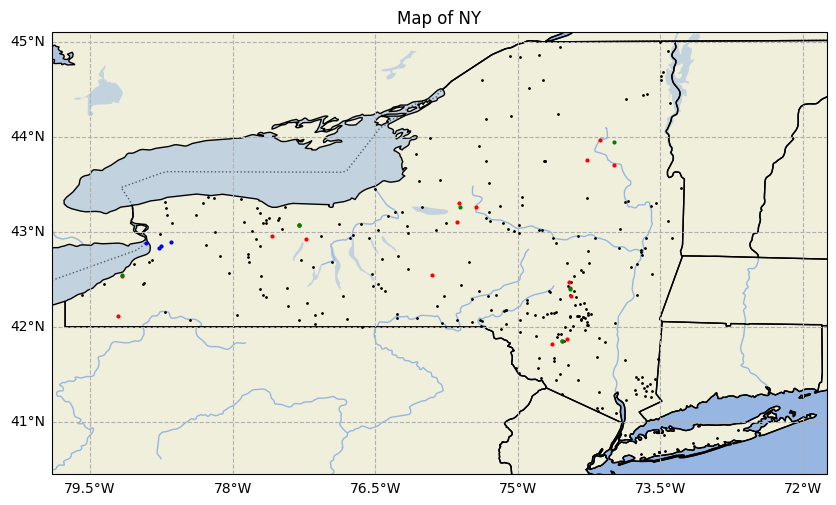

Station 04214500, Coordinates: [42.8546111, -78.7564167], Number of Values = 24836
2%
-910.00: 2005/04/02 - 2005/04/11
-803.00: 1977/09/17 - 1977/09/26
-790.00: 1993/03/26 - 1993/04/04
-765.00: 1973/04/02 - 1973/04/11
-689.00: 1968/01/29 - 1968/02/07
-529.00: 1968/03/19 - 1968/03/28
-468.00: 1963/03/26 - 1963/04/04
-448.00: 1961/04/23 - 1961/05/02
-432.00: 1987/04/02 - 1987/04/11
-419.00: 1981/02/19 - 1981/02/28
-417.00: 2003/03/19 - 2003/03/28
-407.00: 1956/03/05 - 1956/03/14
-407.00: 1959/04/02 - 1959/04/11
-379.00: 1982/03/12 - 1982/03/21
-377.00: 1991/02/05 - 1991/02/14
-360.00: 2014/01/08 - 2014/01/17
-356.00: 1986/03/12 - 1986/03/21
-348.00: 2002/01/29 - 2002/02/07
-336.00: 1985/11/12 - 1985/11/21
-332.00: 1979/03/05 - 1979/03/14
-329.00: 1984/02/12 - 1984/02/21
-325.00: 1976/02/19 - 1976/02/28
-318.00: 1980/03/26 - 1980/04/04
-315.00: 1997/01/22 - 1997/01/31
-313.00: 1977/04/23 - 1977/05/02
-306.00: 1977/03/12 - 1977/03/21
-289.00: 1953/03/26 - 1953/04/04
-282.00: 1965/04/16 - 1

'mapping("NH", 5)\nmapping("VT", 5)\nmapping("ME", 5)\nmapping("RI", 5)\nmapping("MA", 5)\nmapping("CT", 5)'

In [57]:
# Control Panel



'''

for gw instead of just showing 2%, also do same analysis, and values greater than 98%---DONE---


For all 30 or so gw stations 2% of each (fix that function) (how consistent in time are the 2% values)
Want the same thing for stream flow ---I THINK DONE?---

for stream flow
take coordinates of all stations
take radius around coordinates or station
group stations in that radius ---DONE---

take 4 stations and closest together
(center around station and apply station id and radius of 3rd closest)
only import a few days of data
get 3 groups in NY ---DONE---

Values under 2% of those groups of 4 stations ---DONE---


same thing for groundwater stations (30 or so) (map so need coords)---DONE---

List stations and coordinates of origin, and radius
then list 2%---DONE---


Learn cartopy
plot station clusters on map---DONE---








Week of 6/18
Find small clusters in multiple regions around state. Long island, north, West, maybe 6 clusters total, one per area ----DONE
Average centered on that day (day before, day after, day) across week instead of day to day across weeks ----DONE
make code generic that radius can change -- DONE
look in show_site_data() for discrepencies
also..
instead of avg 3 days, work with minimums instead---DONE
only keep if theres at least 2/3 days. only 1 and toss out---DONE

get new set of stations, whittle down
set start of list to 1950
once find stations with lots of data
see how consistently the station reports over time
record missed days, rank by smallest missing data
subtract total values from days in window 

'''

# [114, 414, 410, 496, 60, 47, 476, 635, 484, 599, 55, 74, 644, 305, 376, 359, 280, 42, 278, 97, 657, 624, 623, 192, 136, 405, 397, 77, 619, 51, 497, 202, 525, 135, 440, 78, 99, 210, 590, 616, 177, 279, 667, 238, 1, 419, 626, 577, 386, 264, 266, 267, 185, 341, 371, 545, 356, 130, 648, 331, 536, 439, 350, 309, 39, 429, 271, 333, 14, 15, 610, 389, 390, 373, 622, 437, 438, 385, 22, 26, 637, 669, 272, 666, 11, 33, 28, 444, 25, 491, 493, 13, 16, 32, 360, 489, 518, 137, 579, 551, 654, 187, 12, 292, 67, 558, 299, 443, 409, 35, 487, 71, 10, 351, 312, 247, 552, 505, 614, 636, 607, 605, 34, 587, 483, 182, 284, 342, 561, 162, 490, 287, 596, 620, 101, 649, 514, 402, 455, 480, 150, 538, 277, 355, 76, 64, 470, 257, 417, 447, 383, 469, 662, 560, 629, 121, 41, 334, 68, 450, 392, 102, 479, 406, 571, 120, 562, 119, 5, 197, 152, 70, 124, 243, 265, 563, 363, 307, 573, 72, 582, 442, 19, 529, 404, 516, 73, 337, 138, 2, 3, 6, 52, 49, 255, 256, 344, 352, 20, 506, 606, 4, 377, 31, 485, 643, 196, 295, 30, 658, 583, 318, 195, 650, 511, 676, 94, 276, 375, 441, 145, 117, 345, 665, 21, 367, 190, 572, 65, 354, 18, 465, 300, 445, 680, 285, 395, 149, 274, 304, 655, 315, 329, 308, 659, 540, 365, 374, 100, 584, 388, 336, 594, 401, 24, 399, 40, 103, 403, 361, 368, 227, 231, 229, 234, 225, 220, 221, 651, 675, 521, 219, 222, 233, 498, 230, 347]
# 277

# FIX SITE CODE COLLECTION BECAUSE THEY DON'T ACTUALLY HAVE AS MUCH DATA AS THEY SAY THEY DO
# ['SiteCode = 01350000', 'SiteCode = 03011020', 'SiteCode = 01531000', 'SiteCode = 04231600', 'SiteCode = 01325000', 'SiteCode = 01315500', 'SiteCode = 04223000', 'SiteCode = 04266500', 'SiteCode = 04227500', 'SiteCode = 04252500', 'SiteCode = 01321000', 'SiteCode = 01334500', 'SiteCode = 04269000', 'SiteCode = 01426500', 'SiteCode = 01512500', 'SiteCode = 01503000', 'SiteCode = 01421000', 'SiteCode = 01315000', 'SiteCode = 01420500', 'SiteCode = 01346000', 'SiteCode = 04273500', 'SiteCode = 04263000', 'SiteCode = 04262500', 'SiteCode = 01367500', 'SiteCode = 01357500', 'SiteCode = 01529500', 'SiteCode = 01526500', 'SiteCode = 01335754', 'SiteCode = 04260500', 'SiteCode = 01318500', 'SiteCode = 04232000', 'SiteCode = 01371500', 'SiteCode = 04234000', 'SiteCode = 01357499', 'SiteCode = 04216000', 'SiteCode = 01336000', 'SiteCode = 01347000', 'SiteCode = 01372500', 'SiteCode = 04249000', 'SiteCode = 04258000', 'SiteCode = 01362500', 'SiteCode = 01420980', 'SiteCode = 04275500', 'SiteCode = 01375000', 'SiteCode = 01200000', 'SiteCode = 03014500', 'SiteCode = 04264331', 'SiteCode = 04242500', 'SiteCode = 01521500', 'SiteCode = 01413500', 'SiteCode = 01414500', 'SiteCode = 01415000', 'SiteCode = 01365000', 'SiteCode = 01437500', 'SiteCode = 01509000', 'SiteCode = 04235500', 'SiteCode = 01502500', 'SiteCode = 01351500', 'SiteCode = 04270000', 'SiteCode = 01435000', 'SiteCode = 04235000', 'SiteCode = 04215500', 'SiteCode = 01500000', 'SiteCode = 01428500', 'SiteCode = 01312000', 'SiteCode = 04213500', 'SiteCode = 01417000', 'SiteCode = 01436000', 'SiteCode = 01304500', 'SiteCode = 01305000', 'SiteCode = 04256000', 'SiteCode = 01523500', 'SiteCode = 01524500', 'SiteCode = 01510000', 'SiteCode = 04262000', 'SiteCode = 04214500', 'SiteCode = 04215000', 'SiteCode = 01520500', 'SiteCode = 01306500', 'SiteCode = 01308500', 'SiteCode = 04268000', 'SiteCode = 04276500', 'SiteCode = 01417500', 'SiteCode = 04275000', 'SiteCode = 01303000', 'SiteCode = 01310500', 'SiteCode = 01309500', 'SiteCode = 04217000', 'SiteCode = 01308000', 'SiteCode = 04230500', 'SiteCode = 04231000', 'SiteCode = 01304000', 'SiteCode = 01305500', 'SiteCode = 01310000', 'SiteCode = 01505000', 'SiteCode = 04229500', 'SiteCode = 04233000', 'SiteCode = 01358000', 'SiteCode = 04243500', 'SiteCode = 04237496', 'SiteCode = 04271500', 'SiteCode = 01365500', 'SiteCode = 01303500', 'SiteCode = 01423000', 'SiteCode = 01329490', 'SiteCode = 04239000', 'SiteCode = 01425000', 'SiteCode = 04216500', 'SiteCode = 01530500', 'SiteCode = 01311500', 'SiteCode = 04228500', 'SiteCode = 01330500', 'SiteCode = 01302500', 'SiteCode = 01500500', 'SiteCode = 01433500', 'SiteCode = 01376800', 'SiteCode = 04237500', 'SiteCode = 04232050', 'SiteCode = 04257000', 'SiteCode = 04267500', 'SiteCode = 04254500', 'SiteCode = 04253500', 'SiteCode = 01311000', 'SiteCode = 04246500', 'SiteCode = 04227000', 'SiteCode = 01364500', 'SiteCode = 01421900', 'SiteCode = 01496500', 'SiteCode = 04240100', 'SiteCode = 01362200', 'SiteCode = 04230380', 'SiteCode = 01422500', 'SiteCode = 04250750', 'SiteCode = 04261000', 'SiteCode = 01348000', 'SiteCode = 04270200', 'SiteCode = 04232482', 'SiteCode = 01528000', 'SiteCode = 04219000', 'SiteCode = 04225000', 'SiteCode = 01361000', 'SiteCode = 04235250', 'SiteCode = 01420000', 'SiteCode = 01502000', 'SiteCode = 01335500', 'SiteCode = 01327750', 'SiteCode = 04221500', 'SiteCode = 01387450', 'SiteCode = 03013000', 'SiteCode = 04218000', 'SiteCode = 01514000', 'SiteCode = 04221000', 'SiteCode = 04274000', 'SiteCode = 04240010', 'SiteCode = 04265000', 'SiteCode = 01350180', 'SiteCode = 01314000', 'SiteCode = 01436500', 'SiteCode = 01329500', 'SiteCode = 04218518', 'SiteCode = 01525500', 'SiteCode = 01349000', 'SiteCode = 04224775', 'SiteCode = 01529950', 'SiteCode = 04240180', 'SiteCode = 01350140', 'SiteCode = 04240105', 'SiteCode = 01350120', 'SiteCode = 01301500', 'SiteCode = 01370000', 'SiteCode = 01361500', 'SiteCode = 01330000', 'SiteCode = 01350355', 'SiteCode = 01376500', 'SiteCode = 01414000', 'SiteCode = 04240120', 'SiteCode = 01507000', 'SiteCode = 01427500', 'SiteCode = 04240300', 'SiteCode = 01331095', 'SiteCode = 04245000', 'SiteCode = 04216418', 'SiteCode = 01306460', 'SiteCode = 04234061', 'SiteCode = 01529000', 'SiteCode = 04232650', 'SiteCode = 01333500', 'SiteCode = 01437000', 'SiteCode = 01358500', 'SiteCode = 01300000', 'SiteCode = 01300500', 'SiteCode = 01302000', 'SiteCode = 01319000', 'SiteCode = 01317000', 'SiteCode = 01387400', 'SiteCode = 01387420', 'SiteCode = 01497500', 'SiteCode = 01501000', 'SiteCode = 01306495', 'SiteCode = 0423205010', 'SiteCode = 04254000', 'SiteCode = 01301000', 'SiteCode = 01513500', 'SiteCode = 01309990', 'SiteCode = 04227995', 'SiteCode = 04268800', 'SiteCode = 01369500', 'SiteCode = 0142400103', 'SiteCode = 01309950', 'SiteCode = 04273700', 'SiteCode = 04245200', 'SiteCode = 01434025', 'SiteCode = 01369000', 'SiteCode = 04270500', 'SiteCode = 04232100', 'SiteCode = 04279000', 'SiteCode = 01344000', 'SiteCode = 01419500', 'SiteCode = 01511500', 'SiteCode = 04216200', 'SiteCode = 01359750', 'SiteCode = 01350080', 'SiteCode = 01498500', 'SiteCode = 04274500', 'SiteCode = 01306499', 'SiteCode = 01508000', 'SiteCode = 01366500', 'SiteCode = 04240200', 'SiteCode = 01328000', 'SiteCode = 01501500', 'SiteCode = 01306440', 'SiteCode = 0422026250', 'SiteCode = 01425500', 'SiteCode = 04217500', 'SiteCode = 04280450', 'SiteCode = 01422000', 'SiteCode = 01526000', 'SiteCode = 01360640', 'SiteCode = 01418500', 'SiteCode = 01426000', 'SiteCode = 04271815', 'SiteCode = 01434017', 'SiteCode = 01434498', 'SiteCode = 01428000', 'SiteCode = 04273800', 'SiteCode = 04235271', 'SiteCode = 01507500', 'SiteCode = 01510500', 'SiteCode = 01347500', 'SiteCode = 04245236', 'SiteCode = 01522500', 'SiteCode = 01436690', 'SiteCode = 04250200', 'SiteCode = 01527500', 'SiteCode = 01307500', 'SiteCode = 01527000', 'SiteCode = 01313500', 'SiteCode = 01349150', 'SiteCode = 01528700', 'SiteCode = 01505500', 'SiteCode = 01508500', 'SiteCode = 01374701', 'SiteCode = 01374901', 'SiteCode = 01374821', 'SiteCode = 01374941', 'SiteCode = 0137462010', 'SiteCode = 01374505', 'SiteCode = 01374531', 'SiteCode = 04270510', 'SiteCode = 04278300', 'SiteCode = 04233300', 'SiteCode = 0137449480', 'SiteCode = 01374559', 'SiteCode = 01374930', 'SiteCode = 04232034', 'SiteCode = 01374890', 'SiteCode = 01499000']
import statistics as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

state = "NY"

# Year analysis begins
start_date = "1950"

# Year analysis ends
end_date = "2022"

# Specific date start ("01-05" for Jan 1 - Dec 31)
date = "01-01"

# Distance in weeks looked in each direction of date 
window_in_wks = 0.5
# determines which percentile is graphed, can be list of multiple percentiles
percentile = [5]

# determines how many days you look in each direction
scope = 4

# how many clusters to appear in each section
clusters = 2

#data = get_usgs_sf(state, start_date, end_date)

# IF GETTING DATA FROM CODE, SET SITE TO 0
#data = get_usgs_sf_code("04216000", start_date, end_date)

#for i in range(num_of_reps(data,0)):
    #print(f"{get_gw_date(data,0,i)}: {get_gw_value(data,0,i)}")
#print(data["value"]["timeSeries"][0])

'''
date_data = []
for week in range(int(26 / window_in_wks) + 1):
    date_data.append({})
for stat in show_site_data(data, 0, False):
    new_date = dt.datetime(int(stat[0:4]),int(stat[5:7]),int(stat[8:10]))
    date_data[((new_date.timetuple().tm_yday - 1) // 7)][stat] = show_site_data(data, 0, False)[stat]
graph_comparison(date_data, "01-01", start_date, end_date, 0, window_in_wks, True, percentile, scope, "avg")'''
#percent(data, "01-05", start_date, end_date, percentile, state, "all")
#percentile = [5,10,25,33]
#a = percent(data, "01-05", start_date, end_date, percentile, state, "0")
#differences(data, "01-14", start_date, end_date, 0, window_in_wks)
# ^ STATS IS NONETYPE FIX THIS BROKEN
#show_site_data(data,0,True)
#data = get_usgs_sf2(state, "2023-01-01", "2023-01-02")
#print(coord_clusters(5, data))
#mapping("NY", 2, None)
cluster_using_all_wks(state, clusters, 1, start_date, end_date, 2, scope, "min")
# typ can = "min" or "avg"
#using_all_weeks(data, date, start_date, end_date, 0, 2, scope, "avg")

'''mapping("NH", 5)
mapping("VT", 5)
mapping("ME", 5)
mapping("RI", 5)
mapping("MA", 5)
mapping("CT", 5)'''


#get_station_info(data, start_date, end_date)

If I were to organize this beautifully, how would i do that?

Get station information
    Enter start year for collection:
    End year auto set to 2022 or 2023

    OUTPUT DATA

Get single station data
    Enter station code:
    Enter start year for collection:
    End year auto set to 2022 or 2023

    Range to look at:
    Monthly
    Week range (0.5-2) (1 to 4 weeks)
    Use all weeks

    Enter start date for analysis (one week range ahead of first lookat date)

    Statistics to apply:
    Graph percentile of data:
    Apply differences modification

    OUTPUT GRAPH AND DATA


In [12]:
# IMPORT DATA
station_code = []
start_year = []
end_year = 2023

# RANGE TO ANALYZE
monthly = False
week_range = [1]
use_all_weeks = False
start_date = "01-05"

# STATISTICS TO APPLY
graph_percentile = []
apply_differences = []


